# Neural integration for constitutive equations 

### Benchmark #2: porous, elasto-plastic material

Authors: Filippo Masi, Itai Einav

### 1. Import libraries

In [1]:
# Importing necessary libraries
import pickle
import numpy as np
import torch
from scipy.optimize import root
from torchdiffeq import odeint
from nice_module import NICE, EarlyStopping, slice_data, get_params

# Setting random seeds for reproducibility
np.random.seed(6)
torch.manual_seed(6)

# Plotting configurations
import matplotlib.pyplot as plt
import matplotlib

# Using a classic style for plots
plt.style.use('classic')

# Updating plot configurations
plt.rcParams.update({"axes.grid": False, "grid.color": 'black', "grid.alpha": 0.4})
font = {'size': 11}
matplotlib.rc('font', **font)

# Setting background color for plots
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'

# Setting figure size and layout parameters
plt.rcParams["figure.figsize"] = (2.5, 2)
plt.tight_layout(pad=2.5, w_pad=3.5, h_pad=3.5)
colorb = (0.2, 0.4, 0.7)

<Figure size 200x160 with 0 Axes>

#### 1.1 Set hyperparameters

In [2]:
# Setting the frequency in epochs for printing loss during training
verbose_frequency = 10

# Step size for training process. Set to 20 for reproducing training, else 1 for faster training.
step_size = 1

# Defining the device for training (CUDA if available, else CPU)
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

# Boolean flag for adding normally distributed noise to the training dataset
corrupted_training_data = False

# If corrupted_training_data is True, set the noise amplitude (percentage)
delta = 0.

### 2. Import and prepare data sets

In [3]:
# File path for the training dataset
file = './dataset/benchmark2_data_training'

# Loading data from the specified file using pickle
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

# Unpacking the loaded data into individual variables
strain_t, strain_tdt, r_t, r_tdt, z_t, z_tdt, stress_t, dt, n_reset = data

# Setting batch_time to the value of n_reset
batch_time = n_reset

# Setting data_size to the value of n_reset
data_size = n_reset

# Dimensionality of the data
dim = 2

# Computing the time step parameter prm_dt
prm_dt = 1 / data_size

#### 3.1 Reshape 


In [4]:
# Computing finite differences to get rates of change
dstrain = strain_tdt - strain_t
dr = r_tdt - r_t
dz = z_tdt - z_t

# Normalizing the finite differences by the time step parameter prm_dt
dstrain /= prm_dt
dr /= prm_dt
dz /= prm_dt

# Reshaping arrays for compatibility with the model
strain_t = np.reshape(strain_t, (batch_time, -1, dim), order='F')
strain_tdt = np.reshape(strain_tdt, (batch_time, -1, dim), order='F')
dstrain = np.reshape(dstrain, (batch_time, -1, dim), order='F')
r_t = np.reshape(r_t, (batch_time, -1, 1), order='F')
dr = np.reshape(dr, (batch_time, -1, 1), order='F')
z_t = np.reshape(z_t, (batch_time, -1, 1), order='F')
dz = np.reshape(dz, (batch_time, -1, 1), order='F')
stress_t = np.reshape(stress_t, (batch_time, -1, dim), order='F')

# Updating data_size based on the reshaped strain_t array
data_size = strain_t.shape[0]

# Determining the number of initial conditions (IC) based on the reshaped strain_t array
number_IC = strain_t.shape[1]

#### 3.2 Split data in training, validation, and test sets 

In [5]:
# Percentage of data reserved for training
train_percentage = .65

# Calculating the number of samples for training, validation, and testing
train = int(round(number_IC * train_percentage))
val = int(round(number_IC * 0.5 * (1. - train_percentage)))
test = val

# Displaying information about the dataset split
print("Number of samples: ", number_IC)
print("Training samples : ", train)
print("Validation samples : ", val)
print("Test samples : ", test)
print("Total : ", test + val + train)

Number of samples:  52
Training samples :  34
Validation samples :  9
Test samples :  9
Total :  52


In [6]:
# Generating an array of consecutive numbers representing samples
n = np.arange(0, number_IC, 1)

# Creating a shuffled index array
rnd = np.arange(len(n))
np.random.shuffle(rnd[:-4])
n = n[rnd]

# Splitting the indices for training, validation, and test sets
ntrain = n[:train-4]
ntrain = np.hstack((ntrain, n[-4:]))
cut = len(ntrain)
nval = n[train:train+val]
ntrainval = np.hstack((ntrain, nval))
ntest = n[train+val:]

# Shuffling the indices for the combined training and validation set
rnd = np.arange(len(ntrainval))
np.random.shuffle(rnd)

# Creating separate indices for training and validation sets
ntrain = rnd[:train]
nval = rnd[val:]

In [7]:
# Slicing the data arrays based on the generated indices for training and validation sets (strain)
strain_t_tv, strain_t_test = slice_data(strain_t, ntrainval, ntest)
# (finite differences of strain)
dstrain_tv, dstrain_test = slice_data(dstrain, ntrainval, ntest)

# Slicing the data arrays based on the generated indices for training and validation sets (stress)
stress_t_tv, stress_t_test = slice_data(stress_t, ntrainval, ntest)

# Slicing the data arrays based on the generated indices for training and validation sets (r)
r_t_tv, r_t_test = slice_data(r_t, ntrainval, ntest)
# (finite differences of r)
dr_tv, dr_test = slice_data(dr, ntrainval, ntest)

# Slicing the data arrays based on the generated indices for training and validation sets (z)
z_t_tv, z_t_test = slice_data(z_t, ntrainval, ntest)
# (finite differences of z)
dz_tv, dz_test = slice_data(dz, ntrainval, ntest)

In [8]:
# Get parameters for training data and move to the specified device (strain)
prm_e = get_params(strain_t_tv).to(device)
# (finite differences of strain)
prm_de = get_params(dstrain_tv).to(device)

# Get parameters for training data (stress)
prm_s = get_params(stress_t_tv).to(device)

# Get parameters for training data (density)
prm_r = get_params(r_t_tv).to(device)
# (finite differences of density)
prm_dr = get_params(dr_tv).to(device)

# Get parameters for training data (dissipative state variables, z)
prm_z = get_params(z_t_tv).to(device)
# (finite differences of z)
prm_dz = get_params(dz_tv).to(device)

In [9]:
# Calculate the change in state variables over time
dsvars_tv = z_t_tv - z_t_tv[0]

# Compute normalization parameters for the change in state variables
prm_deltaz = get_params(dsvars_tv)

# Calculate the change in stress over time for each component
ddstress_tv = stress_t_tv[:, :, :dim] - stress_t_tv[0, :, :dim]

# Initialize a list to store normalization parameters for the change in stress
prm_deltas = [] 

# Iterate over each component and compute normalization parameters for the change in stress
for i in range(dsvars_tv.shape[1]):
    # Compute normalization parameters for the change in stress component
    prm_ = get_params(ddstress_tv[:, i])
    
    # Append the computed parameters to the list
    prm_deltas.append(prm_)

In [10]:
if corrupted_training_data:
    # Stress noise vector
    noise = delta/100 * np.random.normal(0, 1, ((data_size + 1, number_IC, dim)))
    
    # Corrupt stress with noise
    noise_stress_t = stress_t_tv.copy()
    noise_stress_t[:,:,0] = np.mean(stress_t_tv[:,:,0]) * noise[:-1,:,0]
    noise_stress_t[:,:,1] = np.mean(stress_t_tv[:,:,1]) * noise[:-1,:,1]
    noise_stress_t[0] *= 0.0
    stress_t_tv += noise_stress_t
    
    # Dissipative state variable noise vector
    noise = delta/100 * np.random.normal(0, 1, ((data_size + 1, number_IC, 1)))
    
    # Corrupt state variable with noise
    noise_svars_z_t = z_t_tv.copy()
    noise_svars_z_tdt = z_tdt_tv.copy()
    noise_svars_z_t = np.mean(z_t_tv) * noise[:-1, :]
    noise_svars_z_tdt = np.mean(z_tdt_tv) * noise[1:, :]
    noise_svars_z_t[0] *= 0.0
    z_t_tv[:, :] += noise_svars_z_t
    z_tdt_tv[:, :] += noise_svars_z_tdt
    
    # Evaluate corrupted rate
    dz_tv = (z_tdt_tv - z_t_tv) / prm_dt

### 4. Neural integration for constitutive equations

#### 4.1 Constructu neural net and set integration scheme

In [11]:
dtype = torch.float64
hidden_num = 0
NNf_params = [2*dim+2, dim+1, [6*(2*dim+3), 6*(2*dim+3), 6*(2*dim+3)], 'gelu']
NNu_params = [dim+2, 1, [2**6, 2**6], 'softplus']
norm_params = [prm_e, prm_de, prm_r, prm_z, prm_dz, prm_s, prm_dt]

# Creating a NICE network with specified parameters and moving it to the device
NICE_network = NICE(NNf_params, NNu_params, len(ntrainval), norm_params, dim, dtype).to(device)
NICE_network.to(torch.double)

NICE(
  (NeuralNetEvolution): Sequential(
    (0): Linear(in_features=6, out_features=42, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=42, out_features=42, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=42, out_features=42, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=42, out_features=3, bias=True)
  )
  (NeuralNetEnergy): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (relu): ReLU()
)

In [12]:
# Calculating time points based on the time step parameter prm_dt
t = torch.arange(0, 1.0, prm_dt)

# Converting stress and strain data to PyTorch tensors and moving them to the specified device (training set)
stress_tv = torch.from_numpy(np.float64(stress_t_tv)).to(device)
dstrain_tv = torch.from_numpy(np.float64(dstrain_tv)).to(device)

# Converting stress and strain data to PyTorch tensors and moving them to the specified device (test set)
stress_test = torch.from_numpy(np.float64(stress_t_test)).to(device)
dstrain_test = torch.from_numpy(np.float64(dstrain_test)).to(device)

# Concatenating state variables and converting to PyTorch tensors (training set)
svars_tv = torch.cat((torch.from_numpy(np.float64(r_t_tv)), torch.from_numpy(np.float64(z_t_tv))), -1).to(device)

# Concatenating state variables and converting to PyTorch tensors (test set)
svars_test = torch.cat((torch.from_numpy(np.float64(r_t_test)), torch.from_numpy(np.float64(z_t_test))), -1).to(device)

In [13]:
# Configuring the NICE network parameters
NICE_network.solver = "midpoint"
NICE_network.scheme = "forward"
NICE_network.step_size = prm_dt / step_size

# Initializing interpolation for the NICE network
NICE_network.init_interp(dstrain_tv, t)

# Turning off the inference mode
NICE_network.inference = False

#### 4.2 Training

In [14]:
# Optimizer, loss function, and hyperparameters
learningRate = 1e-2
optimizer = torch.optim.Adam(NICE_network.parameters(), lr=learningRate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
w_reg = 1.e-5  # L2 penalty weight
Nepochs = 1000000  # Number of epochs
MSE = torch.nn.MSELoss()

# Early stopping criterion
checkpoint_path = './checkpoints/checkpoint_benchmark2_dense.pt'
early_stopping = EarlyStopping(patience=5000, delta=1.e-9, verbose=False, path=checkpoint_path)

# Lists for storing training and validation loss
training_loss_hist = []
validation_loss_value_hist = []

In [15]:
# Initial state variable for optimization
par_svars0 = svars_tv[0]
par_svars0.requires_grad = True

# Training loop
for epoch in range(1, Nepochs):
    # Zeroing gradients before backward pass
    optimizer.zero_grad()

    # Extracting initial conditions for stress and state variables
    ueps_e_0 = NICE_network.DeNormalize(NICE_network.e0, NICE_network.prm_ee)
    usvars0 = torch.cat((ueps_e_0, par_svars0), -1)
    stress0 = NICE_network.stress([ueps_e_0, par_svars0[:, :1], par_svars0[:, 1:]])

    # Prediction using NICE network
    pred = NICE_network.integrate(dstrain_tv, usvars0, t, np.hstack((ntrain, nval)))
    pred_svars, pred_stress, pred_diss = pred

    # Calculate training loss for each sequence
    training_loss_stress = 0.
    training_loss_r0 = 0.
    training_loss_svars = 0.0
    for i in range(len(ntrain)):
        training_loss_stress += MSE(NICE_network.Normalize(pred_stress[:,ntrain[i]]-stress_tv[0,ntrain[i]], prm_deltas[i]),
                               NICE_network.Normalize(stress_tv[:,ntrain[i]]-stress_tv[0,ntrain[i]], prm_deltas[i]))
        training_loss_svars += MSE(NICE_network.Normalize(pred_svars[:,ntrain[i],-1]-svars_tv[0,ntrain[i],-1], prm_deltaz),
                               NICE_network.Normalize(svars_tv[:,ntrain[i],-1]-svars_tv[0,ntrain[i],-1], prm_deltaz))
        
        
    for i in range(len(ntrainval)):
        training_loss_r0 += MSE(NICE_network.Normalize(stress0[i]-stress_tv[0,i], prm_deltas[i]),
                          NICE_network.Normalize(stress_tv[0,i]-stress_tv[0,i], prm_deltas[i]))
        
    # Normalization factor for dissipation
    norm_d = torch.max(torch.abs(pred_diss)).detach()
    training_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, ntrain])/norm_d, pred_diss[:, ntrain].detach()*0)

    # L2 regularization term
    l_reg = torch.tensor(0., requires_grad=True)
    for name, param in NICE_network.named_parameters():
        if 'weight' in name:
            l_reg = l_reg + pow(param, 2).sum()

    # Total training loss
    training_loss = (torch.mean(training_loss_stress)
                     + torch.mean(training_loss_r0)
                     + torch.mean(training_loss_svars)
                     + torch.mean(training_loss_dissipation)
                     + w_reg * l_reg
                     )

    # Backward pass and optimization step
    training_loss.backward()
    optimizer.step()

    # Learning rate decay
    if scheduler.get_last_lr()[0] > 1.e-4:
        scheduler.step()

    # Validation loss components
    
    validation_loss_svars = 0.0
    validation_loss_stress = 0.0
    for i in range(len(nval)):
        validation_loss_stress += MSE(NICE_network.Normalize(pred_stress[:,nval[i]]-stress_tv[0,nval[i]], prm_deltas[nval[i]]),
                               NICE_network.Normalize(stress_tv[:,nval[i]]-stress_tv[0,nval[i]], prm_deltas[nval[i]]))
        validation_loss_svars += MSE(NICE_network.Normalize(pred_svars[:,nval[i],-1]-svars_tv[0,nval[i],-1], prm_deltaz),
                               NICE_network.Normalize(svars_tv[:,nval[i],-1]-svars_tv[0,nval[i],-1], prm_deltaz))
    
    validation_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, nval])/norm_d, pred_diss[:, nval].detach()*0)

    # Total validation loss
    validation_loss = (torch.mean(validation_loss_stress)
                       + torch.mean(validation_loss_svars)
                       + torch.mean(validation_loss_dissipation))

    # Extracting loss values for monitoring
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()

    # Storing loss values for plotting
    training_loss_hist.append(training_loss_value)
    validation_loss_value_hist.append(validation_loss_value)

    # Print loss every 'verbose_frequency' epochs
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch} | training loss: {training_loss_value:.4e} | validation loss: {validation_loss_value:.4e}")

    # Early stopping check
    early_stopping(validation_loss_value, NICE_network)
    
    # If early stopping criteria are met, break the loop
    if early_stopping.early_stop:
        print("Early stopping")
        # Load the best model
        NICE_network.load_state_dict(torch.load(checkpoint_path))
        break

Epoch: 10 | training loss: 2.3261e+02 | validation loss: 5.1530e+01
Epoch: 20 | training loss: 1.3300e+02 | validation loss: 4.4090e+01
Epoch: 30 | training loss: 5.9282e+01 | validation loss: 2.3278e+01
Epoch: 40 | training loss: 3.0789e+01 | validation loss: 1.4310e+01
Epoch: 50 | training loss: 1.5767e+01 | validation loss: 5.5897e+00
Epoch: 60 | training loss: 8.7496e+00 | validation loss: 4.5852e+00
Epoch: 70 | training loss: 4.7119e+00 | validation loss: 3.1545e+00
Epoch: 80 | training loss: 2.4846e+00 | validation loss: 1.9407e+00
Epoch: 90 | training loss: 1.4361e+00 | validation loss: 1.5953e+00
Epoch: 100 | training loss: 9.9321e-01 | validation loss: 1.0098e+00
Epoch: 110 | training loss: 8.0352e-01 | validation loss: 7.4046e-01
Epoch: 120 | training loss: 6.8637e-01 | validation loss: 5.4857e-01
Epoch: 130 | training loss: 5.9386e-01 | validation loss: 4.8135e-01
Epoch: 140 | training loss: 5.2552e-01 | validation loss: 4.3305e-01
Epoch: 150 | training loss: 4.7267e-01 | va

Epoch: 1200 | training loss: 2.5613e-02 | validation loss: 3.5549e-02
Epoch: 1210 | training loss: 2.5371e-02 | validation loss: 3.5262e-02
Epoch: 1220 | training loss: 2.5135e-02 | validation loss: 3.4981e-02
Epoch: 1230 | training loss: 2.4905e-02 | validation loss: 3.4705e-02
Epoch: 1240 | training loss: 2.4682e-02 | validation loss: 3.4436e-02
Epoch: 1250 | training loss: 2.4464e-02 | validation loss: 3.4173e-02
Epoch: 1260 | training loss: 2.4252e-02 | validation loss: 3.3915e-02
Epoch: 1270 | training loss: 2.4045e-02 | validation loss: 3.3662e-02
Epoch: 1280 | training loss: 2.3843e-02 | validation loss: 3.3415e-02
Epoch: 1290 | training loss: 2.3647e-02 | validation loss: 3.3173e-02
Epoch: 1300 | training loss: 2.3455e-02 | validation loss: 3.2936e-02
Epoch: 1310 | training loss: 2.3268e-02 | validation loss: 3.2704e-02
Epoch: 1320 | training loss: 2.3086e-02 | validation loss: 3.2477e-02
Epoch: 1330 | training loss: 2.2908e-02 | validation loss: 3.2255e-02
Epoch: 1340 | traini

Epoch: 2380 | training loss: 1.4932e-02 | validation loss: 2.1709e-02
Epoch: 2390 | training loss: 1.4900e-02 | validation loss: 2.1665e-02
Epoch: 2400 | training loss: 1.4868e-02 | validation loss: 2.1621e-02
Epoch: 2410 | training loss: 1.4837e-02 | validation loss: 2.1578e-02
Epoch: 2420 | training loss: 1.4806e-02 | validation loss: 2.1535e-02
Epoch: 2430 | training loss: 1.4775e-02 | validation loss: 2.1492e-02
Epoch: 2440 | training loss: 1.4745e-02 | validation loss: 2.1450e-02
Epoch: 2450 | training loss: 1.4714e-02 | validation loss: 2.1409e-02
Epoch: 2460 | training loss: 1.4685e-02 | validation loss: 2.1368e-02
Epoch: 2470 | training loss: 1.4655e-02 | validation loss: 2.1327e-02
Epoch: 2480 | training loss: 1.4626e-02 | validation loss: 2.1287e-02
Epoch: 2490 | training loss: 1.4597e-02 | validation loss: 2.1247e-02
Epoch: 2500 | training loss: 1.4569e-02 | validation loss: 2.1207e-02
Epoch: 2510 | training loss: 1.4541e-02 | validation loss: 2.1168e-02
Epoch: 2520 | traini

Epoch: 3560 | training loss: 1.2652e-02 | validation loss: 1.8491e-02
Epoch: 3570 | training loss: 1.2641e-02 | validation loss: 1.8474e-02
Epoch: 3580 | training loss: 1.2630e-02 | validation loss: 1.8458e-02
Epoch: 3590 | training loss: 1.2619e-02 | validation loss: 1.8442e-02
Epoch: 3600 | training loss: 1.2608e-02 | validation loss: 1.8426e-02
Epoch: 3610 | training loss: 1.2597e-02 | validation loss: 1.8410e-02
Epoch: 3620 | training loss: 1.2586e-02 | validation loss: 1.8394e-02
Epoch: 3630 | training loss: 1.2575e-02 | validation loss: 1.8378e-02
Epoch: 3640 | training loss: 1.2565e-02 | validation loss: 1.8362e-02
Epoch: 3650 | training loss: 1.2554e-02 | validation loss: 1.8347e-02
Epoch: 3660 | training loss: 1.2543e-02 | validation loss: 1.8331e-02
Epoch: 3670 | training loss: 1.2533e-02 | validation loss: 1.8316e-02
Epoch: 3680 | training loss: 1.2522e-02 | validation loss: 1.8301e-02
Epoch: 3690 | training loss: 1.2512e-02 | validation loss: 1.8285e-02
Epoch: 3700 | traini

Epoch: 4740 | training loss: 1.1736e-02 | validation loss: 1.7128e-02
Epoch: 4750 | training loss: 1.1730e-02 | validation loss: 1.7119e-02
Epoch: 4760 | training loss: 1.1724e-02 | validation loss: 1.7110e-02
Epoch: 4770 | training loss: 1.1718e-02 | validation loss: 1.7101e-02
Epoch: 4780 | training loss: 1.1712e-02 | validation loss: 1.7092e-02
Epoch: 4790 | training loss: 1.1706e-02 | validation loss: 1.7083e-02
Epoch: 4800 | training loss: 1.1700e-02 | validation loss: 1.7074e-02
Epoch: 4810 | training loss: 1.1694e-02 | validation loss: 1.7064e-02
Epoch: 4820 | training loss: 1.1688e-02 | validation loss: 1.7055e-02
Epoch: 4830 | training loss: 1.1682e-02 | validation loss: 1.7046e-02
Epoch: 4840 | training loss: 1.1676e-02 | validation loss: 1.7037e-02
Epoch: 4850 | training loss: 1.1670e-02 | validation loss: 1.7028e-02
Epoch: 4860 | training loss: 1.1664e-02 | validation loss: 1.7018e-02
Epoch: 4870 | training loss: 1.1658e-02 | validation loss: 1.7009e-02
Epoch: 4880 | traini

Epoch: 5920 | training loss: 1.0884e-02 | validation loss: 1.5813e-02
Epoch: 5930 | training loss: 1.0875e-02 | validation loss: 1.5799e-02
Epoch: 5940 | training loss: 1.0867e-02 | validation loss: 1.5785e-02
Epoch: 5950 | training loss: 1.0858e-02 | validation loss: 1.5772e-02
Epoch: 5960 | training loss: 1.0849e-02 | validation loss: 1.5758e-02
Epoch: 5970 | training loss: 1.0841e-02 | validation loss: 1.5744e-02
Epoch: 5980 | training loss: 1.0832e-02 | validation loss: 1.5730e-02
Epoch: 5990 | training loss: 1.0823e-02 | validation loss: 1.5716e-02
Epoch: 6000 | training loss: 1.0814e-02 | validation loss: 1.5702e-02
Epoch: 6010 | training loss: 1.0805e-02 | validation loss: 1.5688e-02
Epoch: 6020 | training loss: 1.0796e-02 | validation loss: 1.5674e-02
Epoch: 6030 | training loss: 1.0788e-02 | validation loss: 1.5660e-02
Epoch: 6040 | training loss: 1.0779e-02 | validation loss: 1.5646e-02
Epoch: 6050 | training loss: 1.0770e-02 | validation loss: 1.5632e-02
Epoch: 6060 | traini

Epoch: 7100 | training loss: 9.6955e-03 | validation loss: 1.3885e-02
Epoch: 7110 | training loss: 9.7539e-03 | validation loss: 1.3751e-02
Epoch: 7120 | training loss: 9.6772e-03 | validation loss: 1.3893e-02
Epoch: 7130 | training loss: 9.6627e-03 | validation loss: 1.3853e-02
Epoch: 7140 | training loss: 9.6503e-03 | validation loss: 1.3818e-02
Epoch: 7150 | training loss: 9.6390e-03 | validation loss: 1.3794e-02
Epoch: 7160 | training loss: 9.6277e-03 | validation loss: 1.3776e-02
Epoch: 7170 | training loss: 9.6164e-03 | validation loss: 1.3759e-02
Epoch: 7180 | training loss: 9.6051e-03 | validation loss: 1.3742e-02
Epoch: 7190 | training loss: 9.5938e-03 | validation loss: 1.3724e-02
Epoch: 7200 | training loss: 9.5824e-03 | validation loss: 1.3704e-02
Epoch: 7210 | training loss: 9.5710e-03 | validation loss: 1.3685e-02
Epoch: 7220 | training loss: 9.5596e-03 | validation loss: 1.3665e-02
Epoch: 7230 | training loss: 9.5482e-03 | validation loss: 1.3646e-02
Epoch: 7240 | traini

Epoch: 8280 | training loss: 8.7052e-03 | validation loss: 1.2063e-02
Epoch: 8290 | training loss: 8.4231e-03 | validation loss: 1.1787e-02
Epoch: 8300 | training loss: 8.3453e-03 | validation loss: 1.1684e-02
Epoch: 8310 | training loss: 8.3089e-03 | validation loss: 1.1623e-02
Epoch: 8320 | training loss: 8.2880e-03 | validation loss: 1.1580e-02
Epoch: 8330 | training loss: 8.2736e-03 | validation loss: 1.1549e-02
Epoch: 8340 | training loss: 8.2613e-03 | validation loss: 1.1523e-02
Epoch: 8350 | training loss: 8.2498e-03 | validation loss: 1.1500e-02
Epoch: 8360 | training loss: 8.2384e-03 | validation loss: 1.1478e-02
Epoch: 8370 | training loss: 8.2272e-03 | validation loss: 1.1457e-02
Epoch: 8380 | training loss: 8.2160e-03 | validation loss: 1.1437e-02
Epoch: 8390 | training loss: 8.2048e-03 | validation loss: 1.1417e-02
Epoch: 8400 | training loss: 8.1936e-03 | validation loss: 1.1399e-02
Epoch: 8410 | training loss: 8.1824e-03 | validation loss: 1.1380e-02
Epoch: 8420 | traini

Epoch: 9460 | training loss: 7.0810e-03 | validation loss: 9.4751e-03
Epoch: 9470 | training loss: 7.0715e-03 | validation loss: 9.4585e-03
Epoch: 9480 | training loss: 7.0621e-03 | validation loss: 9.4419e-03
Epoch: 9490 | training loss: 7.0526e-03 | validation loss: 9.4252e-03
Epoch: 9500 | training loss: 7.0431e-03 | validation loss: 9.4086e-03
Epoch: 9510 | training loss: 7.0336e-03 | validation loss: 9.3919e-03
Epoch: 9520 | training loss: 7.0241e-03 | validation loss: 9.3752e-03
Epoch: 9530 | training loss: 7.0145e-03 | validation loss: 9.3585e-03
Epoch: 9540 | training loss: 7.0050e-03 | validation loss: 9.3417e-03
Epoch: 9550 | training loss: 6.9955e-03 | validation loss: 9.3250e-03
Epoch: 9560 | training loss: 6.9859e-03 | validation loss: 9.3082e-03
Epoch: 9570 | training loss: 6.9764e-03 | validation loss: 9.2914e-03
Epoch: 9580 | training loss: 6.9668e-03 | validation loss: 9.2745e-03
Epoch: 9590 | training loss: 6.9572e-03 | validation loss: 9.2577e-03
Epoch: 9600 | traini

Epoch: 10630 | training loss: 6.1108e-03 | validation loss: 7.7927e-03
Epoch: 10640 | training loss: 6.1036e-03 | validation loss: 7.7808e-03
Epoch: 10650 | training loss: 6.0963e-03 | validation loss: 7.7688e-03
Epoch: 10660 | training loss: 6.0891e-03 | validation loss: 7.7568e-03
Epoch: 10670 | training loss: 6.0818e-03 | validation loss: 7.7448e-03
Epoch: 10680 | training loss: 6.0746e-03 | validation loss: 7.7325e-03
Epoch: 10690 | training loss: 6.0768e-03 | validation loss: 7.7188e-03
Epoch: 10700 | training loss: 7.9809e-03 | validation loss: 8.4579e-03
Epoch: 10710 | training loss: 6.1807e-03 | validation loss: 7.8666e-03
Epoch: 10720 | training loss: 6.1303e-03 | validation loss: 7.7949e-03
Epoch: 10730 | training loss: 6.0812e-03 | validation loss: 7.6769e-03
Epoch: 10740 | training loss: 6.0541e-03 | validation loss: 7.6178e-03
Epoch: 10750 | training loss: 6.0375e-03 | validation loss: 7.6088e-03
Epoch: 10760 | training loss: 6.0252e-03 | validation loss: 7.6165e-03
Epoch:

Epoch: 11790 | training loss: 5.4453e-03 | validation loss: 6.8502e-03
Epoch: 11800 | training loss: 5.4405e-03 | validation loss: 6.8445e-03
Epoch: 11810 | training loss: 5.4357e-03 | validation loss: 6.8389e-03
Epoch: 11820 | training loss: 5.4309e-03 | validation loss: 6.8332e-03
Epoch: 11830 | training loss: 5.4261e-03 | validation loss: 6.8275e-03
Epoch: 11840 | training loss: 5.4213e-03 | validation loss: 6.8219e-03
Epoch: 11850 | training loss: 5.4165e-03 | validation loss: 6.8162e-03
Epoch: 11860 | training loss: 5.4117e-03 | validation loss: 6.8105e-03
Epoch: 11870 | training loss: 5.4069e-03 | validation loss: 6.8049e-03
Epoch: 11880 | training loss: 5.4020e-03 | validation loss: 6.7993e-03
Epoch: 11890 | training loss: 5.3973e-03 | validation loss: 6.7952e-03
Epoch: 11900 | training loss: 5.4054e-03 | validation loss: 6.8169e-03
Epoch: 11910 | training loss: 7.4794e-03 | validation loss: 7.9984e-03
Epoch: 11920 | training loss: 5.3847e-03 | validation loss: 6.7685e-03
Epoch:

Epoch: 12950 | training loss: 4.9726e-03 | validation loss: 6.3822e-03
Epoch: 12960 | training loss: 4.9691e-03 | validation loss: 6.3794e-03
Epoch: 12970 | training loss: 4.9655e-03 | validation loss: 6.3765e-03
Epoch: 12980 | training loss: 4.9619e-03 | validation loss: 6.3736e-03
Epoch: 12990 | training loss: 4.9583e-03 | validation loss: 6.3707e-03
Epoch: 13000 | training loss: 4.9547e-03 | validation loss: 6.3678e-03
Epoch: 13010 | training loss: 4.9511e-03 | validation loss: 6.3649e-03
Epoch: 13020 | training loss: 4.9475e-03 | validation loss: 6.3619e-03
Epoch: 13030 | training loss: 4.9439e-03 | validation loss: 6.3589e-03
Epoch: 13040 | training loss: 4.9403e-03 | validation loss: 6.3557e-03
Epoch: 13050 | training loss: 4.9370e-03 | validation loss: 6.3494e-03
Epoch: 13060 | training loss: 5.0166e-03 | validation loss: 6.3287e-03
Epoch: 13070 | training loss: 5.6460e-03 | validation loss: 6.4614e-03
Epoch: 13080 | training loss: 5.3928e-03 | validation loss: 6.4174e-03
Epoch:

Epoch: 14110 | training loss: 4.6143e-03 | validation loss: 6.1268e-03
Epoch: 14120 | training loss: 4.6162e-03 | validation loss: 6.1504e-03
Epoch: 14130 | training loss: 4.6088e-03 | validation loss: 6.1282e-03
Epoch: 14140 | training loss: 4.6064e-03 | validation loss: 6.1254e-03
Epoch: 14150 | training loss: 4.6036e-03 | validation loss: 6.1329e-03
Epoch: 14160 | training loss: 4.6008e-03 | validation loss: 6.1258e-03
Epoch: 14170 | training loss: 4.5981e-03 | validation loss: 6.1270e-03
Epoch: 14180 | training loss: 4.5954e-03 | validation loss: 6.1238e-03
Epoch: 14190 | training loss: 4.5927e-03 | validation loss: 6.1231e-03
Epoch: 14200 | training loss: 4.5901e-03 | validation loss: 6.1205e-03
Epoch: 14210 | training loss: 4.5874e-03 | validation loss: 6.1193e-03
Epoch: 14220 | training loss: 4.5847e-03 | validation loss: 6.1177e-03
Epoch: 14230 | training loss: 4.5820e-03 | validation loss: 6.1160e-03
Epoch: 14240 | training loss: 4.5793e-03 | validation loss: 6.1144e-03
Epoch:

Epoch: 15270 | training loss: 5.2252e-03 | validation loss: 6.5323e-03
Epoch: 15280 | training loss: 5.3388e-03 | validation loss: 6.1466e-03
Epoch: 15290 | training loss: 4.6211e-03 | validation loss: 5.9198e-03
Epoch: 15300 | training loss: 4.4192e-03 | validation loss: 5.8805e-03
Epoch: 15310 | training loss: 4.3516e-03 | validation loss: 5.8846e-03
Epoch: 15320 | training loss: 4.3267e-03 | validation loss: 5.8973e-03
Epoch: 15330 | training loss: 4.3177e-03 | validation loss: 5.9071e-03
Epoch: 15340 | training loss: 4.3144e-03 | validation loss: 5.9124e-03
Epoch: 15350 | training loss: 4.3126e-03 | validation loss: 5.9148e-03
Epoch: 15360 | training loss: 4.3104e-03 | validation loss: 5.9129e-03
Epoch: 15370 | training loss: 4.3080e-03 | validation loss: 5.9078e-03
Epoch: 15380 | training loss: 4.3058e-03 | validation loss: 5.9039e-03
Epoch: 15390 | training loss: 4.3037e-03 | validation loss: 5.9020e-03
Epoch: 15400 | training loss: 4.3015e-03 | validation loss: 5.9012e-03
Epoch:

Epoch: 16430 | training loss: 4.0999e-03 | validation loss: 5.7113e-03
Epoch: 16440 | training loss: 4.0982e-03 | validation loss: 5.7086e-03
Epoch: 16450 | training loss: 4.0964e-03 | validation loss: 5.7073e-03
Epoch: 16460 | training loss: 4.0946e-03 | validation loss: 5.7059e-03
Epoch: 16470 | training loss: 4.0928e-03 | validation loss: 5.7042e-03
Epoch: 16480 | training loss: 4.0910e-03 | validation loss: 5.7027e-03
Epoch: 16490 | training loss: 4.0892e-03 | validation loss: 5.7017e-03
Epoch: 16500 | training loss: 4.0880e-03 | validation loss: 5.7050e-03
Epoch: 16510 | training loss: 4.1344e-03 | validation loss: 5.7716e-03
Epoch: 16520 | training loss: 5.7077e-03 | validation loss: 6.6954e-03
Epoch: 16530 | training loss: 4.1036e-03 | validation loss: 5.7667e-03
Epoch: 16540 | training loss: 4.1522e-03 | validation loss: 5.6954e-03
Epoch: 16550 | training loss: 4.1357e-03 | validation loss: 5.6642e-03
Epoch: 16560 | training loss: 4.0893e-03 | validation loss: 5.6546e-03
Epoch:

Epoch: 17590 | training loss: 3.9568e-03 | validation loss: 5.6172e-03
Epoch: 17600 | training loss: 3.9244e-03 | validation loss: 5.5970e-03
Epoch: 17610 | training loss: 3.9189e-03 | validation loss: 5.5873e-03
Epoch: 17620 | training loss: 3.9150e-03 | validation loss: 5.5598e-03
Epoch: 17630 | training loss: 3.9106e-03 | validation loss: 5.5653e-03
Epoch: 17640 | training loss: 3.9085e-03 | validation loss: 5.5591e-03
Epoch: 17650 | training loss: 3.9069e-03 | validation loss: 5.5527e-03
Epoch: 17660 | training loss: 3.9060e-03 | validation loss: 5.5536e-03
Epoch: 17670 | training loss: 3.9160e-03 | validation loss: 5.5830e-03
Epoch: 17680 | training loss: 4.3386e-03 | validation loss: 5.9358e-03
Epoch: 17690 | training loss: 3.9634e-03 | validation loss: 5.4960e-03
Epoch: 17700 | training loss: 4.0409e-03 | validation loss: 5.6930e-03
Epoch: 17710 | training loss: 3.9312e-03 | validation loss: 5.5077e-03
Epoch: 17720 | training loss: 3.8972e-03 | validation loss: 5.5383e-03
Epoch:

Epoch: 18750 | training loss: 3.7891e-03 | validation loss: 5.4645e-03
Epoch: 18760 | training loss: 3.9174e-03 | validation loss: 5.5818e-03
Epoch: 18770 | training loss: 3.7804e-03 | validation loss: 5.4692e-03
Epoch: 18780 | training loss: 3.7711e-03 | validation loss: 5.4119e-03
Epoch: 18790 | training loss: 3.7675e-03 | validation loss: 5.4139e-03
Epoch: 18800 | training loss: 3.7616e-03 | validation loss: 5.4344e-03
Epoch: 18810 | training loss: 3.7602e-03 | validation loss: 5.4310e-03
Epoch: 18820 | training loss: 3.7589e-03 | validation loss: 5.4213e-03
Epoch: 18830 | training loss: 3.7575e-03 | validation loss: 5.4249e-03
Epoch: 18840 | training loss: 3.7563e-03 | validation loss: 5.4230e-03
Epoch: 18850 | training loss: 3.7551e-03 | validation loss: 5.4212e-03
Epoch: 18860 | training loss: 3.7540e-03 | validation loss: 5.4208e-03
Epoch: 18870 | training loss: 3.7528e-03 | validation loss: 5.4192e-03
Epoch: 18880 | training loss: 3.7516e-03 | validation loss: 5.4180e-03
Epoch:

Epoch: 19910 | training loss: 3.6572e-03 | validation loss: 5.2673e-03
Epoch: 19920 | training loss: 3.6487e-03 | validation loss: 5.2763e-03
Epoch: 19930 | training loss: 3.6457e-03 | validation loss: 5.2924e-03
Epoch: 19940 | training loss: 3.6445e-03 | validation loss: 5.2909e-03
Epoch: 19950 | training loss: 3.6434e-03 | validation loss: 5.2831e-03
Epoch: 19960 | training loss: 3.6423e-03 | validation loss: 5.2844e-03
Epoch: 19970 | training loss: 3.6414e-03 | validation loss: 5.2831e-03
Epoch: 19980 | training loss: 3.6405e-03 | validation loss: 5.2803e-03
Epoch: 19990 | training loss: 3.6396e-03 | validation loss: 5.2803e-03
Epoch: 20000 | training loss: 3.6386e-03 | validation loss: 5.2784e-03
Epoch: 20010 | training loss: 3.6377e-03 | validation loss: 5.2774e-03
Epoch: 20020 | training loss: 3.6367e-03 | validation loss: 5.2759e-03
Epoch: 20030 | training loss: 3.6358e-03 | validation loss: 5.2746e-03
Epoch: 20040 | training loss: 3.6349e-03 | validation loss: 5.2733e-03
Epoch:

Epoch: 21070 | training loss: 3.5470e-03 | validation loss: 5.1364e-03
Epoch: 21080 | training loss: 3.5463e-03 | validation loss: 5.1410e-03
Epoch: 21090 | training loss: 3.5454e-03 | validation loss: 5.1401e-03
Epoch: 21100 | training loss: 3.5447e-03 | validation loss: 5.1403e-03
Epoch: 21110 | training loss: 3.5457e-03 | validation loss: 5.1478e-03
Epoch: 21120 | training loss: 3.6067e-03 | validation loss: 5.2272e-03
Epoch: 21130 | training loss: 4.4860e-03 | validation loss: 5.7810e-03
Epoch: 21140 | training loss: 3.7047e-03 | validation loss: 5.1309e-03
Epoch: 21150 | training loss: 3.5518e-03 | validation loss: 5.1206e-03
Epoch: 21160 | training loss: 3.5780e-03 | validation loss: 5.1913e-03
Epoch: 21170 | training loss: 3.5454e-03 | validation loss: 5.1166e-03
Epoch: 21180 | training loss: 3.5385e-03 | validation loss: 5.1272e-03
Epoch: 21190 | training loss: 3.5382e-03 | validation loss: 5.1308e-03
Epoch: 21200 | training loss: 3.5373e-03 | validation loss: 5.1206e-03
Epoch:

Epoch: 22230 | training loss: 3.4668e-03 | validation loss: 5.0082e-03
Epoch: 22240 | training loss: 3.4741e-03 | validation loss: 4.9958e-03
Epoch: 22250 | training loss: 3.4696e-03 | validation loss: 4.9917e-03
Epoch: 22260 | training loss: 3.4623e-03 | validation loss: 4.9967e-03
Epoch: 22270 | training loss: 3.4604e-03 | validation loss: 5.0066e-03
Epoch: 22280 | training loss: 3.4600e-03 | validation loss: 5.0096e-03
Epoch: 22290 | training loss: 3.4590e-03 | validation loss: 5.0039e-03
Epoch: 22300 | training loss: 3.4584e-03 | validation loss: 5.0003e-03
Epoch: 22310 | training loss: 3.4577e-03 | validation loss: 5.0017e-03
Epoch: 22320 | training loss: 3.4570e-03 | validation loss: 5.0007e-03
Epoch: 22330 | training loss: 3.4563e-03 | validation loss: 4.9988e-03
Epoch: 22340 | training loss: 3.4557e-03 | validation loss: 4.9985e-03
Epoch: 22350 | training loss: 3.4550e-03 | validation loss: 4.9970e-03
Epoch: 22360 | training loss: 3.4543e-03 | validation loss: 4.9962e-03
Epoch:

Epoch: 23390 | training loss: 3.3909e-03 | validation loss: 4.9004e-03
Epoch: 23400 | training loss: 3.3902e-03 | validation loss: 4.8964e-03
Epoch: 23410 | training loss: 3.3896e-03 | validation loss: 4.8953e-03
Epoch: 23420 | training loss: 3.3890e-03 | validation loss: 4.8958e-03
Epoch: 23430 | training loss: 3.3885e-03 | validation loss: 4.8954e-03
Epoch: 23440 | training loss: 3.3879e-03 | validation loss: 4.8956e-03
Epoch: 23450 | training loss: 3.3888e-03 | validation loss: 4.9015e-03
Epoch: 23460 | training loss: 3.4537e-03 | validation loss: 4.9753e-03
Epoch: 23470 | training loss: 4.5025e-03 | validation loss: 5.5869e-03
Epoch: 23480 | training loss: 3.4516e-03 | validation loss: 4.8989e-03
Epoch: 23490 | training loss: 3.4799e-03 | validation loss: 4.8805e-03
Epoch: 23500 | training loss: 3.3970e-03 | validation loss: 4.9046e-03
Epoch: 23510 | training loss: 3.3931e-03 | validation loss: 4.9026e-03
Epoch: 23520 | training loss: 3.3880e-03 | validation loss: 4.8778e-03
Epoch:

Epoch: 24550 | training loss: 3.3318e-03 | validation loss: 4.8281e-03
Epoch: 24560 | training loss: 3.3365e-03 | validation loss: 4.8381e-03
Epoch: 24570 | training loss: 3.4578e-03 | validation loss: 4.9488e-03
Epoch: 24580 | training loss: 3.6963e-03 | validation loss: 5.0920e-03
Epoch: 24590 | training loss: 3.4400e-03 | validation loss: 4.7815e-03
Epoch: 24600 | training loss: 3.3540e-03 | validation loss: 4.8479e-03
Epoch: 24610 | training loss: 3.3336e-03 | validation loss: 4.7846e-03
Epoch: 24620 | training loss: 3.3289e-03 | validation loss: 4.8154e-03
Epoch: 24630 | training loss: 3.3268e-03 | validation loss: 4.7879e-03
Epoch: 24640 | training loss: 3.3239e-03 | validation loss: 4.8036e-03
Epoch: 24650 | training loss: 3.3227e-03 | validation loss: 4.7990e-03
Epoch: 24660 | training loss: 3.3222e-03 | validation loss: 4.7932e-03
Epoch: 24670 | training loss: 3.3221e-03 | validation loss: 4.7907e-03
Epoch: 24680 | training loss: 3.3248e-03 | validation loss: 4.7838e-03
Epoch:

Epoch: 25710 | training loss: 3.6659e-03 | validation loss: 4.7417e-03
Epoch: 25720 | training loss: 3.3680e-03 | validation loss: 4.6898e-03
Epoch: 25730 | training loss: 3.2831e-03 | validation loss: 4.7255e-03
Epoch: 25740 | training loss: 3.2708e-03 | validation loss: 4.7301e-03
Epoch: 25750 | training loss: 3.2737e-03 | validation loss: 4.7317e-03
Epoch: 25760 | training loss: 3.2760e-03 | validation loss: 4.7228e-03
Epoch: 25770 | training loss: 3.3192e-03 | validation loss: 4.6973e-03
Epoch: 25780 | training loss: 3.8373e-03 | validation loss: 4.8055e-03
Epoch: 25790 | training loss: 3.4227e-03 | validation loss: 4.8654e-03
Epoch: 25800 | training loss: 3.3349e-03 | validation loss: 4.6942e-03
Epoch: 25810 | training loss: 3.2942e-03 | validation loss: 4.7638e-03
Epoch: 25820 | training loss: 3.2764e-03 | validation loss: 4.7041e-03
Epoch: 25830 | training loss: 3.2684e-03 | validation loss: 4.7290e-03
Epoch: 25840 | training loss: 3.2661e-03 | validation loss: 4.7195e-03
Epoch:

Epoch: 26870 | training loss: 3.2222e-03 | validation loss: 4.6638e-03
Epoch: 26880 | training loss: 3.2218e-03 | validation loss: 4.6634e-03
Epoch: 26890 | training loss: 3.2217e-03 | validation loss: 4.6656e-03
Epoch: 26900 | training loss: 3.2970e-03 | validation loss: 4.7634e-03
Epoch: 26910 | training loss: 3.2869e-03 | validation loss: 4.6204e-03
Epoch: 26920 | training loss: 3.3152e-03 | validation loss: 4.6240e-03
Epoch: 26930 | training loss: 3.5482e-03 | validation loss: 4.6593e-03
Epoch: 26940 | training loss: 3.3423e-03 | validation loss: 4.7610e-03
Epoch: 26950 | training loss: 3.2631e-03 | validation loss: 4.6145e-03
Epoch: 26960 | training loss: 3.2289e-03 | validation loss: 4.6699e-03
Epoch: 26970 | training loss: 3.2188e-03 | validation loss: 4.6518e-03
Epoch: 26980 | training loss: 3.2206e-03 | validation loss: 4.6440e-03
Epoch: 26990 | training loss: 3.2175e-03 | validation loss: 4.6572e-03
Epoch: 27000 | training loss: 3.2181e-03 | validation loss: 4.6632e-03
Epoch:

Epoch: 28030 | training loss: 3.1780e-03 | validation loss: 4.6144e-03
Epoch: 28040 | training loss: 3.1777e-03 | validation loss: 4.6144e-03
Epoch: 28050 | training loss: 3.1773e-03 | validation loss: 4.6137e-03
Epoch: 28060 | training loss: 3.1769e-03 | validation loss: 4.6134e-03
Epoch: 28070 | training loss: 3.1766e-03 | validation loss: 4.6131e-03
Epoch: 28080 | training loss: 3.1762e-03 | validation loss: 4.6128e-03
Epoch: 28090 | training loss: 3.1758e-03 | validation loss: 4.6126e-03
Epoch: 28100 | training loss: 3.1756e-03 | validation loss: 4.6136e-03
Epoch: 28110 | training loss: 3.1826e-03 | validation loss: 4.6287e-03
Epoch: 28120 | training loss: 4.0142e-03 | validation loss: 5.1306e-03
Epoch: 28130 | training loss: 3.9374e-03 | validation loss: 4.8117e-03
Epoch: 28140 | training loss: 3.2220e-03 | validation loss: 4.5840e-03
Epoch: 28150 | training loss: 3.1817e-03 | validation loss: 4.6142e-03
Epoch: 28160 | training loss: 3.1963e-03 | validation loss: 4.6416e-03
Epoch:

Epoch: 29190 | training loss: 3.1389e-03 | validation loss: 4.5812e-03
Epoch: 29200 | training loss: 3.1379e-03 | validation loss: 4.5738e-03
Epoch: 29210 | training loss: 3.1375e-03 | validation loss: 4.5797e-03
Epoch: 29220 | training loss: 3.1370e-03 | validation loss: 4.5736e-03
Epoch: 29230 | training loss: 3.1365e-03 | validation loss: 4.5763e-03
Epoch: 29240 | training loss: 3.1362e-03 | validation loss: 4.5766e-03
Epoch: 29250 | training loss: 3.1358e-03 | validation loss: 4.5757e-03
Epoch: 29260 | training loss: 3.1355e-03 | validation loss: 4.5757e-03
Epoch: 29270 | training loss: 3.1354e-03 | validation loss: 4.5775e-03
Epoch: 29280 | training loss: 3.1479e-03 | validation loss: 4.5978e-03
Epoch: 29290 | training loss: 3.9552e-03 | validation loss: 5.0780e-03
Epoch: 29300 | training loss: 3.6481e-03 | validation loss: 4.6928e-03
Epoch: 29310 | training loss: 3.1534e-03 | validation loss: 4.5910e-03
Epoch: 29320 | training loss: 3.2053e-03 | validation loss: 4.6445e-03
Epoch:

Epoch: 30350 | training loss: 3.1015e-03 | validation loss: 4.5452e-03
Epoch: 30360 | training loss: 3.1238e-03 | validation loss: 4.5321e-03
Epoch: 30370 | training loss: 4.3684e-03 | validation loss: 4.9253e-03
Epoch: 30380 | training loss: 3.5455e-03 | validation loss: 4.8291e-03
Epoch: 30390 | training loss: 3.1564e-03 | validation loss: 4.6070e-03
Epoch: 30400 | training loss: 3.1229e-03 | validation loss: 4.5413e-03
Epoch: 30410 | training loss: 3.1186e-03 | validation loss: 4.5420e-03
Epoch: 30420 | training loss: 3.1003e-03 | validation loss: 4.5576e-03
Epoch: 30430 | training loss: 3.1011e-03 | validation loss: 4.5575e-03
Epoch: 30440 | training loss: 3.0990e-03 | validation loss: 4.5435e-03
Epoch: 30450 | training loss: 3.0982e-03 | validation loss: 4.5458e-03
Epoch: 30460 | training loss: 3.0979e-03 | validation loss: 4.5484e-03
Epoch: 30470 | training loss: 3.0976e-03 | validation loss: 4.5461e-03
Epoch: 30480 | training loss: 3.0973e-03 | validation loss: 4.5473e-03
Epoch:

Epoch: 31510 | training loss: 3.0731e-03 | validation loss: 4.5437e-03
Epoch: 31520 | training loss: 3.0708e-03 | validation loss: 4.5418e-03
Epoch: 31530 | training loss: 3.0694e-03 | validation loss: 4.5399e-03
Epoch: 31540 | training loss: 3.0803e-03 | validation loss: 4.5562e-03
Epoch: 31550 | training loss: 3.3034e-03 | validation loss: 4.7204e-03
Epoch: 31560 | training loss: 3.1558e-03 | validation loss: 4.6095e-03
Epoch: 31570 | training loss: 3.0818e-03 | validation loss: 4.5163e-03
Epoch: 31580 | training loss: 3.0665e-03 | validation loss: 4.5353e-03
Epoch: 31590 | training loss: 3.0654e-03 | validation loss: 4.5283e-03
Epoch: 31600 | training loss: 3.0657e-03 | validation loss: 4.5330e-03
Epoch: 31610 | training loss: 3.0664e-03 | validation loss: 4.5227e-03
Epoch: 31620 | training loss: 3.0656e-03 | validation loss: 4.5341e-03
Epoch: 31630 | training loss: 3.0642e-03 | validation loss: 4.5290e-03
Epoch: 31640 | training loss: 3.0642e-03 | validation loss: 4.5257e-03
Epoch:

Epoch: 32670 | training loss: 3.0364e-03 | validation loss: 4.5187e-03
Epoch: 32680 | training loss: 3.0361e-03 | validation loss: 4.5186e-03
Epoch: 32690 | training loss: 3.0358e-03 | validation loss: 4.5184e-03
Epoch: 32700 | training loss: 3.0356e-03 | validation loss: 4.5184e-03
Epoch: 32710 | training loss: 3.0353e-03 | validation loss: 4.5183e-03
Epoch: 32720 | training loss: 3.0350e-03 | validation loss: 4.5185e-03
Epoch: 32730 | training loss: 3.0351e-03 | validation loss: 4.5226e-03
Epoch: 32740 | training loss: 3.1132e-03 | validation loss: 4.6294e-03
Epoch: 32750 | training loss: 3.1219e-03 | validation loss: 4.5442e-03
Epoch: 32760 | training loss: 3.0424e-03 | validation loss: 4.5168e-03
Epoch: 32770 | training loss: 3.0376e-03 | validation loss: 4.5288e-03
Epoch: 32780 | training loss: 3.0379e-03 | validation loss: 4.5372e-03
Epoch: 32790 | training loss: 3.0354e-03 | validation loss: 4.5294e-03
Epoch: 32800 | training loss: 3.0344e-03 | validation loss: 4.5243e-03
Epoch:

Epoch: 33830 | training loss: 3.0083e-03 | validation loss: 4.5088e-03
Epoch: 33840 | training loss: 3.0667e-03 | validation loss: 4.5060e-03
Epoch: 33850 | training loss: 4.5252e-03 | validation loss: 5.0372e-03
Epoch: 33860 | training loss: 3.0956e-03 | validation loss: 4.5042e-03
Epoch: 33870 | training loss: 3.0291e-03 | validation loss: 4.5295e-03
Epoch: 33880 | training loss: 3.0533e-03 | validation loss: 4.5543e-03
Epoch: 33890 | training loss: 3.0261e-03 | validation loss: 4.5384e-03
Epoch: 33900 | training loss: 3.0070e-03 | validation loss: 4.5193e-03
Epoch: 33910 | training loss: 3.0074e-03 | validation loss: 4.5108e-03
Epoch: 33920 | training loss: 3.0064e-03 | validation loss: 4.5094e-03
Epoch: 33930 | training loss: 3.0055e-03 | validation loss: 4.5125e-03
Epoch: 33940 | training loss: 3.0052e-03 | validation loss: 4.5134e-03
Epoch: 33950 | training loss: 3.0050e-03 | validation loss: 4.5119e-03
Epoch: 33960 | training loss: 3.0047e-03 | validation loss: 4.5120e-03
Epoch:

Epoch: 34990 | training loss: 2.9811e-03 | validation loss: 4.5102e-03
Epoch: 35000 | training loss: 2.9809e-03 | validation loss: 4.5102e-03
Epoch: 35010 | training loss: 2.9807e-03 | validation loss: 4.5101e-03
Epoch: 35020 | training loss: 2.9805e-03 | validation loss: 4.5100e-03
Epoch: 35030 | training loss: 2.9802e-03 | validation loss: 4.5100e-03
Epoch: 35040 | training loss: 2.9800e-03 | validation loss: 4.5100e-03
Epoch: 35050 | training loss: 2.9798e-03 | validation loss: 4.5105e-03
Epoch: 35060 | training loss: 2.9811e-03 | validation loss: 4.5197e-03
Epoch: 35070 | training loss: 3.3853e-03 | validation loss: 4.8826e-03
Epoch: 35080 | training loss: 3.2616e-03 | validation loss: 4.6090e-03
Epoch: 35090 | training loss: 3.0558e-03 | validation loss: 4.4848e-03
Epoch: 35100 | training loss: 3.0037e-03 | validation loss: 4.4802e-03
Epoch: 35110 | training loss: 2.9836e-03 | validation loss: 4.5047e-03
Epoch: 35120 | training loss: 2.9838e-03 | validation loss: 4.5162e-03
Epoch:

Epoch: 36150 | training loss: 2.9561e-03 | validation loss: 4.5085e-03
Epoch: 36160 | training loss: 2.9559e-03 | validation loss: 4.5079e-03
Epoch: 36170 | training loss: 2.9557e-03 | validation loss: 4.5082e-03
Epoch: 36180 | training loss: 2.9555e-03 | validation loss: 4.5079e-03
Epoch: 36190 | training loss: 2.9552e-03 | validation loss: 4.5079e-03
Epoch: 36200 | training loss: 2.9550e-03 | validation loss: 4.5079e-03
Epoch: 36210 | training loss: 2.9548e-03 | validation loss: 4.5078e-03
Epoch: 36220 | training loss: 2.9546e-03 | validation loss: 4.5079e-03
Epoch: 36230 | training loss: 2.9544e-03 | validation loss: 4.5085e-03
Epoch: 36240 | training loss: 2.9577e-03 | validation loss: 4.5154e-03
Epoch: 36250 | training loss: 3.3634e-03 | validation loss: 4.7587e-03
Epoch: 36260 | training loss: 3.1897e-03 | validation loss: 4.5778e-03
Epoch: 36270 | training loss: 3.0308e-03 | validation loss: 4.5805e-03
Epoch: 36280 | training loss: 3.0477e-03 | validation loss: 4.5723e-03
Epoch:

Epoch: 37310 | training loss: 2.9325e-03 | validation loss: 4.5036e-03
Epoch: 37320 | training loss: 2.9346e-03 | validation loss: 4.4995e-03
Epoch: 37330 | training loss: 3.0458e-03 | validation loss: 4.5108e-03
Epoch: 37340 | training loss: 3.6094e-03 | validation loss: 4.7159e-03
Epoch: 37350 | training loss: 2.9369e-03 | validation loss: 4.4906e-03
Epoch: 37360 | training loss: 3.0385e-03 | validation loss: 4.5819e-03
Epoch: 37370 | training loss: 2.9322e-03 | validation loss: 4.5012e-03
Epoch: 37380 | training loss: 2.9427e-03 | validation loss: 4.5014e-03
Epoch: 37390 | training loss: 2.9341e-03 | validation loss: 4.5160e-03
Epoch: 37400 | training loss: 2.9306e-03 | validation loss: 4.5053e-03
Epoch: 37410 | training loss: 2.9307e-03 | validation loss: 4.5033e-03
Epoch: 37420 | training loss: 2.9304e-03 | validation loss: 4.5074e-03
Epoch: 37430 | training loss: 2.9301e-03 | validation loss: 4.5047e-03
Epoch: 37440 | training loss: 2.9299e-03 | validation loss: 4.5057e-03
Epoch:

Epoch: 38470 | training loss: 2.9134e-03 | validation loss: 4.4934e-03
Epoch: 38480 | training loss: 2.9105e-03 | validation loss: 4.5031e-03
Epoch: 38490 | training loss: 2.9110e-03 | validation loss: 4.5048e-03
Epoch: 38500 | training loss: 2.9112e-03 | validation loss: 4.5055e-03
Epoch: 38510 | training loss: 2.9209e-03 | validation loss: 4.5186e-03
Epoch: 38520 | training loss: 3.1347e-03 | validation loss: 4.6626e-03
Epoch: 38530 | training loss: 3.0344e-03 | validation loss: 4.5918e-03
Epoch: 38540 | training loss: 2.9217e-03 | validation loss: 4.4935e-03
Early stopping


#### 4.3 Training and validation set evaluation

In [16]:
# Creating a time vector for evaluation
t = prm_dt * torch.linspace(0., data_size-1, data_size).to(device)

# Enabling gradients for the state variables
svars_tv.requires_grad = True

# Solving for elastic strain using the root-finding method
sol = root(NICE_network.find_elastic_strain,
           args=([svars_tv[0, :, :1].reshape(-1, 1), svars_tv[0, :, -1:].reshape(-1, 1), stress_tv[0].reshape(-1, 2)]),
           x0=np.zeros((len(ntrainval), 2)),
           tol=1e-12)
eps_e_0 = torch.from_numpy(sol.x.reshape(-1, 2))

# De-normalizing elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Creating input for the NICE network
usvars = torch.cat((ueps_e_0, svars_tv[0]), -1)

# Predicting with the NICE network
pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_tv[:], usvars, t, np.hstack((ntrain, nval)))

# Evaluating error using L1 loss
loss = torch.nn.L1Loss()
MAE_stress = loss(NICE_network.Normalize(pred_stress, prm_s), NICE_network.Normalize(stress_tv, prm_s))
MAE_z = loss(NICE_network.Normalize(pred_svars[:, :, -1:], prm_z), NICE_network.Normalize(svars_tv[:, :, -1:], prm_z))

# Printing Mean Absolute Error (MAE) for stress and z
print("MAE stress : ", MAE_stress, "\nMAE z : ", MAE_z)

MAE stress :  tensor(0.0023, dtype=torch.float64, grad_fn=<MeanBackward0>) 
MAE z :  tensor(0.0052, dtype=torch.float64, grad_fn=<MeanBackward0>)


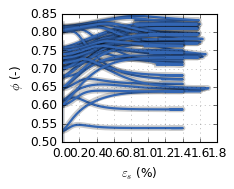

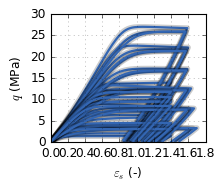

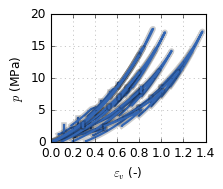

In [17]:
# Plotting strain vs. state variable (phi)
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntrainval)):
    # Plotting actual vs predicted state variable (phi)
    ax.plot(strain_t_tv[:, i, 1], svars_tv[:, i, 1].detach().numpy(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_tv[:, i, 1], pred_svars[:, i, 3].cpu().detach(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$\phi$ (-)')
ax.set_xlabel('$\\varepsilon_s$ (%)')
ax.grid()
plt.show()

# Plotting strain vs. stress (q)
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntrainval)):
    # Plotting actual vs predicted stress (q)
    ax.plot(strain_t_tv[:, i, 1], stress_tv[:, i, 1].cpu().detach(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_tv[:, i, 1], pred_stress[:, i, 1].cpu().detach(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$\\varepsilon_s$ (-)')
ax.set_ylim(0, 30)
ax.grid()
plt.show()

# Plotting strain vs. stress (p)
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntrainval)):
    # Plotting actual vs predicted stress (p)
    ax.plot(strain_t_tv[:, i, 0], stress_tv[:, i, 0].cpu().detach(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_tv[:, i, 0], pred_stress[:, i, 0].cpu().detach(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$p$ (MPa)')
ax.set_xlabel('$\\varepsilon_v$ (-)')
ax.set_ylim(0, 20)
ax.grid()
plt.show()


#### 4.4 Test set evaluation

In [18]:
# Enable gradients for state variables in the test set
svars_test.requires_grad = True

# Creating a time vector for evaluation
t = prm_dt * torch.linspace(0., data_size-1, data_size).to(device)

# Initializing interpolation for the NICE network using test data
NICE_network.init_interp(dstrain_test, t)

# Solving for elastic strain using the root-finding method on the test set
sol = root(NICE_network.find_elastic_strain,
           args=([svars_test[0, :, :1].reshape(-1, 1), svars_test[0, :, -1:].reshape(-1, 1), stress_test[0].reshape(-1, 2)]),
           x0=np.zeros((stress_test.shape[1], 2)),
           tol=1e-12)
eps_e_0 = torch.from_numpy(sol.x.reshape(-1, 2))

# De-normalizing elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Creating input for the NICE network using the test set
usvars = torch.cat((ueps_e_0, svars_test[0]), -1)

# Predicting with the NICE network using the test set
Ntest = np.arange(0, dstrain_test.shape[1])
pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_test, usvars, t, Ntest)

# Evaluating error using L1 loss
loss = torch.nn.L1Loss()
MAE_stress = loss(NICE_network.Normalize(pred_stress, prm_s), NICE_network.Normalize(stress_test, prm_s))
MAE_z = loss(NICE_network.Normalize(pred_svars[:, :, -1:], prm_z), NICE_network.Normalize(svars_test[:, :, -1:], prm_z))

# Printing Mean Absolute Error (MAE) for stress and z on the test set
print("MAE stress : ", MAE_stress,
      "\nMAE z : ", MAE_z)

MAE stress :  tensor(0.0025, dtype=torch.float64, grad_fn=<MeanBackward0>) 
MAE z :  tensor(0.0038, dtype=torch.float64, grad_fn=<MeanBackward0>)


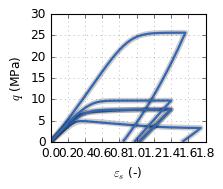

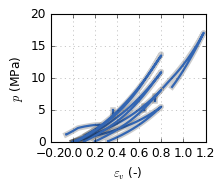

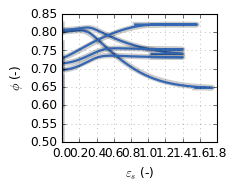

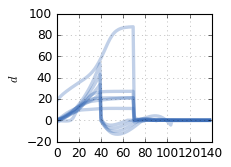

In [19]:
# Plotting strain vs. stress (q) on the test set
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    # Plotting actual vs predicted stress (q)
    ax.plot(strain_t_test[:, i, 1], stress_test[:, i, 1].cpu().detach(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_test[:, i, 1], pred_stress[:, i, 1].cpu().detach(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$\\varepsilon_s$ (-)')
ax.grid()
ax.set_ylim(0, 30)
plt.show()

# Plotting strain vs. stress (p) on the test set
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    # Plotting actual vs predicted stress (p)
    ax.plot(strain_t_test[:, i, 0], stress_test[:, i, 0].cpu().detach(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_test[:, i, 0], pred_stress[:, i, 0].cpu().detach(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$p$ (MPa)')
ax.set_xlabel('$\\varepsilon_v$ (-)')
ax.set_ylim(0, 20)
ax.grid()
plt.show()

# Plotting strain vs. state variable (phi) on the test set
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    # Plotting actual vs predicted state variable (phi)
    ax.plot(strain_t_test[:, i, 1], svars_test[:, i, 1].detach().numpy(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_test[:, i, 1], pred_svars[:, i, 3].detach().numpy(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$\phi$ (-)')
ax.set_xlabel('$\\varepsilon_s$ (-)')
ax.grid()
plt.show()

# Plotting dissipation (d) on the test set
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    # Plotting predicted dissipation (d)
    ax.plot(pred_diss[:, i].cpu().detach(), linewidth=3, alpha=0.3, color=colorb, markersize=0, marker='.')
ax.set_ylabel('$d$')
ax.grid()
plt.show()

### 5. Inference

In [20]:
# Loading data for benchmark2 inference
file = './dataset/benchmark2_inference_UndrainedTriaxial_phi08'
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

# Extracting data from the loaded file
[stress_t, strain_t, svars_e_t, epl, r_t, rs_t, stress_tdt, strain_tdt, svars_e_tdt, epl_tdt, r_tdt, rs_tdt, dt, n_reset] = data

# Setting batch_time and data_size based on the loaded data
batch_time = n_reset
data_size = n_reset

# Calculating the strain protocol
dstrain = (strain_tdt - strain_t) / prm_dt

# Reshaping the data for further processing and analysis
strain_t = np.reshape(strain_t, (batch_time, -1, dim), order='F')
dstrain = np.reshape(dstrain, (batch_time, -1, dim), order='F')
r_t = np.reshape(r_t, (batch_time, -1, 1), order='F')
rs_t = np.reshape(rs_t, (batch_time, -1, 1), order='F')
el_strain_t = np.reshape(svars_e_t, (batch_time, -1, dim), order='F')
stress_t = np.reshape(stress_t, (batch_time, -1, dim), order='F')

# Setting data_size and number of initial conditions based on reshaped data
data_size = strain_t.shape[0]
number_IC = strain_t.shape[1]

# Converting reshaped data to PyTorch tensors and moving to the specified device
svars = torch.cat((torch.from_numpy(np.float64(r_t)), torch.from_numpy(np.float64(rs_t))), -1).to(device)
stress = torch.from_numpy(np.float64(stress_t)).to(device)
dstrain = torch.from_numpy(np.float64(dstrain)).to(device)

In [21]:
# Setting the NICE network for inference mode
NICE_network.inference = True

# Creating a time vector for the inference
t = torch.arange(0, prm_dt * data_size, prm_dt)

# Extracting initial conditions from the first time step of the loaded data
initial_conditions = torch.cat((svars[0, :, :1].reshape(-1, 1), svars[0, :, -1:].reshape(-1, 1),
                                stress[0].reshape(-1, 2)), -1)

In [22]:
# Creating an array of indices for initial conditions
idx = np.arange(0, number_IC)

# Enabling gradients for initial conditions
initial_conditions.requires_grad = True

# Initializing interpolation for the NICE network using the strain data and time vector
NICE_network.init_interp(dstrain, t)

# Solving for elastic strain using the root-finding method on the initial conditions
sol = root(NICE_network.find_elastic_strain,
           args=([initial_conditions[:, :1], initial_conditions[:, 1:2], initial_conditions[:, 2:]]),
           x0=np.zeros((number_IC, dim)),
           tol=1e-12)
eps_e_0 = torch.from_numpy(sol.x.reshape(-1, 2))

# De-normalizing elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Creating input for the NICE network using the solved elastic strain and initial state variables
usvars = torch.cat((ueps_e_0, svars[0]), -1)

# Predicting with the NICE network using the strain data and initial conditions
pred = NICE_network.integrate(dstrain, usvars, t, idx)
pred_svars, pred_stress, pred_diss = pred

# Converting the predicted values to NumPy arrays
pred_svars = pred_svars.cpu().detach().numpy()
pred_stress = pred_stress.cpu().detach().numpy()
pred_diss = pred_diss.cpu().detach().numpy()

In [23]:
# Calculating stress ratios from the loaded stress data
stress_ratio = stress_t[:, :, 1] / stress_t[:, :, 0]

# Calculating stress ratios from the predicted stress values
pred_stress_ratio = pred_stress[:, :, 1] / pred_stress[:, :, 0]

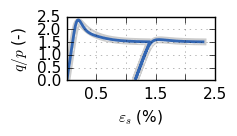

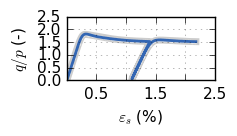

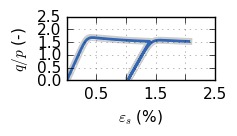

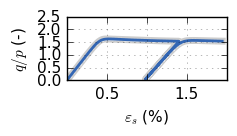

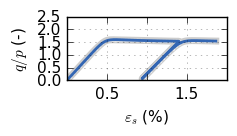

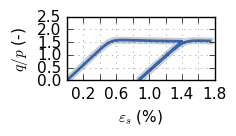

In [24]:
nid = 1

# Loop over different figures for visualization
for idd in range(6):
    # Create a new figure with specified properties
    fig = plt.figure(dpi=100, figsize=(2.5, 1.5), tight_layout=True)
    axes = fig.subplots(1)

    # Plotting reference stress ratio with markers and lines
    axes.plot(strain_t[:, idd:idd + nid, 1], stress_ratio[:, idd:idd + nid], marker='o', markerfacecolor='white',
              linestyle='-', color='black', alpha=0.2, linewidth=5, markersize=0, label='ref')

    # Plotting a subset of reference stress ratio with smaller markers
    axes.plot(strain_t[::2, idd:idd + nid, 1], stress_ratio[::2, idd:idd + nid], marker='o', markerfacecolor='white',
              markeredgewidth=0.0, linestyle='-', color='black', alpha=0.5, linewidth=0, markersize=2.5)

    # Plotting predicted stress ratio with specified properties
    axes.plot(strain_t[:, idd:idd + nid, 1], pred_stress_ratio[:, idd:idd + nid], alpha=1, linewidth=2, color=colorb,
              markersize=0, markeredgewidth=0.0, marker='.')

    # Set labels and customize x-axis tick visibility
    axes.set_ylabel('$q/p$ (-)')
    axes.set_xlabel('$\\varepsilon_s$ (%)')
    every_nth = 2
    for n, label in enumerate(axes.xaxis.get_ticklabels()):
        if n % every_nth == 0:
            label.set_visible(False)

    # Customize the plot appearance and limit the y-axis
    axes.grid()
    axes.set_ylim(0, 2.5)

    # Show the plot
    plt.show()

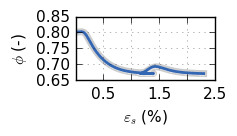

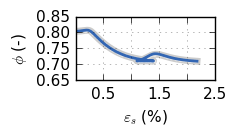

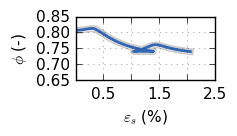

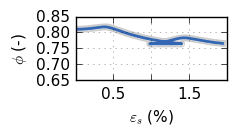

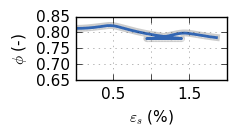

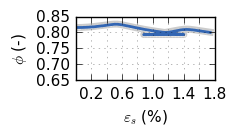

In [25]:
# Loop over different figures for visualization
for idd in range(6):
    # Create a new figure with specified properties
    fig = plt.figure(dpi=100, figsize=(2.5, 1.5), tight_layout=True)
    axes = fig.subplots(1)

    # Plotting reference value of state variable with markers and lines
    axes.plot(strain_t[:, idd:idd + nid, 1], rs_t[:, idd:idd + nid, -1], marker='o', markerfacecolor='white',
              linestyle='-', color='black', alpha=0.2, linewidth=5, markersize=0, label='ref')

    # Plotting a subset of reference values with smaller markers
    axes.plot(strain_t[::2, idd:idd + nid, 1], rs_t[::2, idd:idd + nid, -1], marker='o', markerfacecolor='white',
              markeredgewidth=0.0, linestyle='-', color='black', alpha=0.5, linewidth=0, markersize=2.5)

    # Plotting predicted values of state variable with specified properties
    axes.plot(strain_t[:, idd:idd + nid, 1], pred_svars[:, idd:idd + nid, -1], alpha=1, linewidth=2, color=colorb,
              markersize=0, markeredgewidth=0.0, marker='.')

    # Set labels and customize x-axis tick visibility
    axes.set_ylabel('$\phi$ (-)')
    axes.set_xlabel('$\\varepsilon_s$ (%)')
    axes.grid()
    every_nth = 2
    for n, label in enumerate(axes.xaxis.get_ticklabels()):
        if n % every_nth == 0:
            label.set_visible(False)

    # Customize the plot appearance and limit the y-axis
    axes.set_ylim(0.65,0.85)
    plt.show()

### 6. Save model

In [26]:
# Define the file path for saving the model state dictionary
PATH = './saved/[state]NICE_benchmark2_dense'

# Save the state dictionary of the NICE_network model to the specified file path
torch.save(NICE_network.state_dict(), PATH)

In [27]:
# Define the file path for saving the norm_params list
params_PATH = './saved/[params]NICE_benchmark2_dense'

# Save the norm_params list to the specified file path using pickle
with open(params_PATH, 'wb') as f_obj:
    pickle.dump(norm_params, f_obj)